<a href="https://colab.research.google.com/github/RamanVer1ma/AgroFarm/blob/main/CHSModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

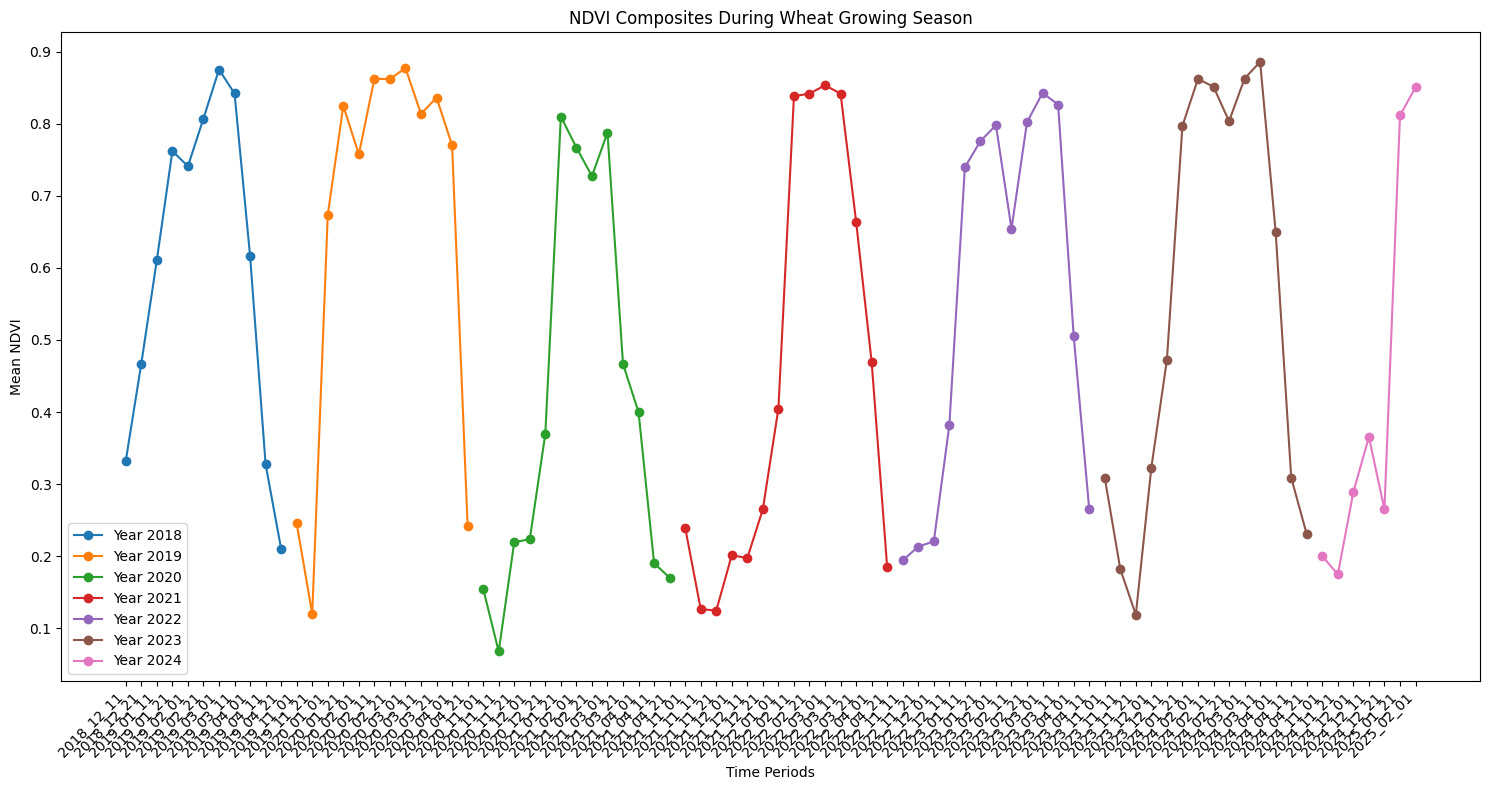

Missing periods: ['2018_11_01', '2018_11_11', '2018_11_21', '2018_12_01', '2019_01_01', '2019_02_11', '2019_03_21']
Missing periods: ['2019_11_11', '2019_12_01', '2019_12_11', '2019_12_21', '2020_01_11', '2020_04_11']
Missing periods: ['2020_12_11', '2021_01_01', '2021_01_11', '2021_02_11', '2021_03_11']
Missing periods: ['2022_01_11', '2022_01_21', '2022_02_01', '2022_04_11']
Missing periods: ['2022_11_01', '2022_12_21', '2023_01_01', '2023_03_21', '2023_04_21']
Missing periods: ['2023_12_21', '2024_01_01', '2024_01_11', '2024_03_21']
Missing periods: ['2024_11_11', '2025_01_01', '2025_01_11', '2025_02_11', '2025_02_21', '2025_03_01', '2025_03_11', '2025_03_21', '2025_04_01', '2025_04_11', '2025_04_21']


In [7]:
import ee
import geemap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

ee.Authenticate()
ee.Initialize(project = 'agrofram')

def create_date_ranges(year):
    periods = []
    # Months from November of current year to April of next year
    months_config = [
        (11, year),    # November current year
        (12, year),    # December current year
        (1, year+1),   # January next year
        (2, year+1),   # February next year
        (3, year+1),   # March next year
        (4, year+1)    # April next year
    ]

    for month, year_to_use in months_config:
        for day_start in [1, 11, 21]:
            # Create start and end dates for 10-day periods
            start_date = ee.Date(f'{year_to_use}-{month:02d}-{day_start:02d}')
            end_date = start_date.advance(10, 'day')

            periods.append({
                'start': start_date,
                'end': end_date,
                'label': f'{year_to_use}_{month:02d}_{day_start:02d}'
            })

    return periods

def load_and_process_ndvi(year, region):
    """
    Load Sentinel images and calculate NDVI composites for 5-10 day periods
    """
    # Get date ranges for the year
    periods = create_date_ranges(year)

    ndvi_composites = []

    for period in periods:
        # Load Sentinel-2 images for the period
        collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterDate(period['start'], period['end']) \
            .filterBounds(region) \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))

        # If no images, append None
        if collection.size().getInfo() == 0:
            ndvi_composites.append({
                'date': period['label'],
                'ndvi': None
            })
            continue

        # Calculate NDVI composite
        ndvi_composite = collection \
            .map(lambda image: image.normalizedDifference(['B8', 'B4']).rename('NDVI')) \
            .mean()

        # Extract mean NDVI value
        mean_ndvi = ndvi_composite.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=10,
            maxPixels=1e9
        ).get('NDVI').getInfo()

        ndvi_composites.append({
            'date': period['label'],
            'ndvi': mean_ndvi
        })

    return ndvi_composites

def plot_ndvi_composites(ndvi_data):
    """
    Plot NDVI composites across years
    """
    plt.figure(figsize=(15, 8))

    # Prepare data for plotting
    all_dates = []
    all_ndvis = []

    for year_data in ndvi_data:
        dates = [entry['date'] for entry in year_data if entry['ndvi'] is not None]
        ndvis = [entry['ndvi'] for entry in year_data if entry['ndvi'] is not None]

        plt.plot(dates, ndvis, marker='o', label=f'Year {dates[0][:4]}')

        all_dates.extend(dates)
        all_ndvis.extend(ndvis)

    plt.title('NDVI Composites During Wheat Growing Season')
    plt.xlabel('Time Periods')
    plt.ylabel('Mean NDVI')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return all_dates, all_ndvis

def main():
    # Define region of interest (example: Punjab, India)
    xmin, ymin = 75.84399, 30.81936
    xmax, ymax = 75.85511, 30.82714
    punjab = ee.Geometry.Rectangle([75.84399, 30.81936,75.85511, 30.82714])

    # Process NDVI for last 5 years
    ndvi_data = []
    for year in range(2018, 2025):
        year_ndvi = load_and_process_ndvi(year, punjab)
        ndvi_data.append(year_ndvi)

    # Plot NDVI composites
    dates, ndvis = plot_ndvi_composites(ndvi_data)

    # Print out details of missing data
    for year_data in ndvi_data:
        missing_periods = [entry['date'] for entry in year_data if entry['ndvi'] is None]
        if missing_periods:
            print(f"Missing periods: {missing_periods}")

if __name__ == '__main__':
    main()

In [8]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

ee.Authenticate()
ee.Initialize(project = 'agrofram')

def generate_full_timestamp_range(start_year, end_year):
    """
    Generate complete timestamp range for wheat growing season
    """
    timestamps = []
    for year in range(start_year, end_year + 1):
        # Wheat growing season from Nov to May
        current_date = datetime(year, 11, 1)
        season_end = datetime(year + 1, 5, 31)

        while current_date <= season_end:
            timestamps.append(current_date)
            current_date += timedelta(days=10)

    return timestamps

def load_ndvi_for_period(start_date, end_date, region):
    """
    Load Sentinel images and calculate NDVI for specific period
    """
    # Convert datetime to ee.Date
    start = ee.Date(start_date.strftime('%Y-%m-%d'))
    end = ee.Date(end_date.strftime('%Y-%m-%d'))

    # Load Sentinel-2 images
    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterDate(start, end) \
        .filterBounds(region) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))

    # If no images, return None
    if collection.size().getInfo() == 0:
        return None

    # Calculate NDVI composite
    ndvi_composite = collection \
        .map(lambda image: image.normalizedDifference(['B8', 'B4']).rename('NDVI')) \
        .mean()

    # Extract mean NDVI value
    try:
        mean_ndvi = ndvi_composite.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=10,
            maxPixels=1e9
        ).get('NDVI').getInfo()
        return mean_ndvi
    except:
        return None

def create_ndvi_dataset(start_year, end_year):
    """
    Create comprehensive NDVI dataset
    """
  # Define region of interest (example: Punjab, India)
    xmin, ymin = 75.84399, 30.81936
    xmax, ymax = 75.85511, 30.82714
    punjab = ee.Geometry.Rectangle([75.84399, 30.81936,75.85511, 30.82714])


    # Generate full timestamp range
    timestamps = generate_full_timestamp_range(start_year, end_year)

    # Prepare data collection
    data = []
    for timestamp in timestamps:
        # 10-day period
        period_end = timestamp + timedelta(days=10)

        # Calculate NDVI
        ndvi = load_ndvi_for_period(timestamp, period_end, punjab)

        data.append({
            'timestamp': timestamp,
            'NDVIi': ndvi
        })

    # Convert to DataFrame
    df = pd.DataFrame(data)
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month

    return df

def plot_ndvi_dataset(df):
    """
    Plot NDVI dataset with missing values highlighted
    """
    plt.figure(figsize=(15, 8))

    # Group by year and plot
    for year in df['year'].unique():
        year_data = df[df['year'] == year]

        # Plot available NDVI values
        available = year_data[year_data['NDVIi'].notna()]
        plt.plot(available['timestamp'], available['NDVIi'],
                 marker='o', linestyle='-', label=f'Year {year}')

        # Highlight missing values
        missing = year_data[year_data['NDVIi'].isna()]
        if not missing.empty:
            plt.scatter(missing['timestamp'], [0]*len(missing),
                        color='red', marker='x', s=100)

    plt.title('NDVI Time Series with Missing Periods')
    plt.xlabel('Timestamp')
    plt.ylabel('NDVI Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return df

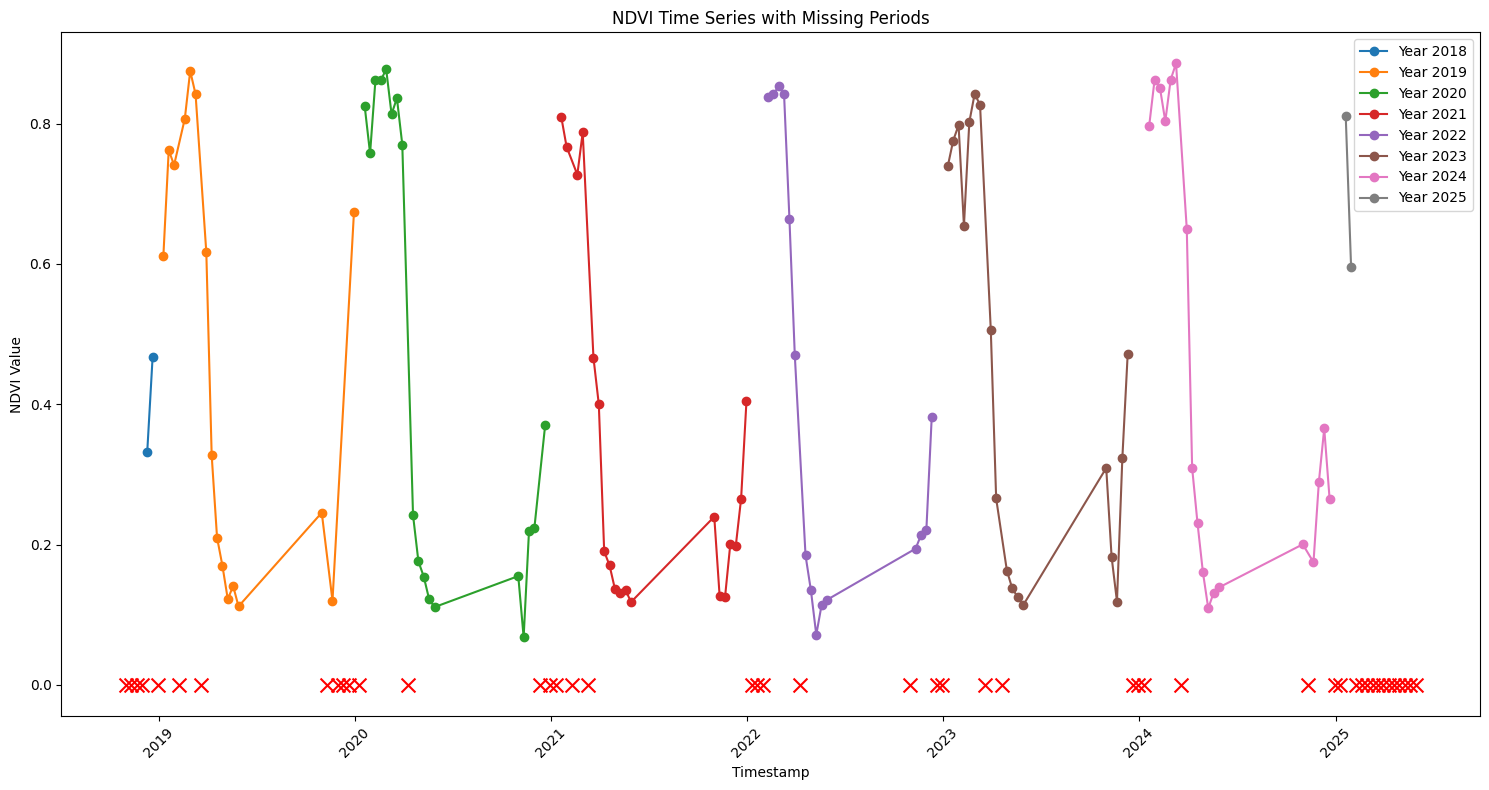

Missing NDVI Periods:
     timestamp  year  month
0   2018-11-01  2018     11
1   2018-11-11  2018     11
2   2018-11-21  2018     11
3   2018-12-01  2018     12
6   2018-12-31  2018     12
10  2019-02-09  2019      2
14  2019-03-21  2019      3
23  2019-11-11  2019     11
25  2019-12-01  2019     12
26  2019-12-11  2019     12
27  2019-12-21  2019     12
29  2020-01-10  2020      1
38  2020-04-09  2020      4
48  2020-12-11  2020     12
50  2020-12-31  2020     12
51  2021-01-10  2021      1
54  2021-02-09  2021      2
57  2021-03-11  2021      3
73  2022-01-10  2022      1
74  2022-01-20  2022      1
75  2022-01-30  2022      1
82  2022-04-10  2022      4
88  2022-11-01  2022     11
93  2022-12-21  2022     12
94  2022-12-31  2022     12
102 2023-03-21  2023      3
105 2023-04-20  2023      4
115 2023-12-21  2023     12
116 2023-12-31  2023     12
117 2024-01-10  2024      1
124 2024-03-20  2024      3
133 2024-11-11  2024     11
138 2024-12-31  2024     12
139 2025-01-10  2025      

In [9]:

 # Generate NDVI dataset
ndvi_df = create_ndvi_dataset(2018, 2024)

    # Plot and display results
result_df = plot_ndvi_dataset(ndvi_df)

    # Print summary of missing data
missing_summary = result_df[result_df['NDVIi'].isna()]
print("Missing NDVI Periods:")
print(missing_summary[['timestamp', 'year', 'month']])



In [10]:
result_df

,timestamp,NDVIi,year,month
0,2018-11-01,NaN,2018,11
1,2018-11-11,NaN,2018,11
2,2018-11-21,NaN,2018,11
3,2018-12-01,NaN,2018,12
4,2018-12-11,0.332155,2018,12
...,...,...,...,...
149,2025-04-20,NaN,2025,4
150,2025-04-30,NaN,2025,4
151,2025-05-10,NaN,2025,5
152,2025-05-20,NaN,2025,5


In [11]:
print(result_df['NDVIi'].isna().sum())

46


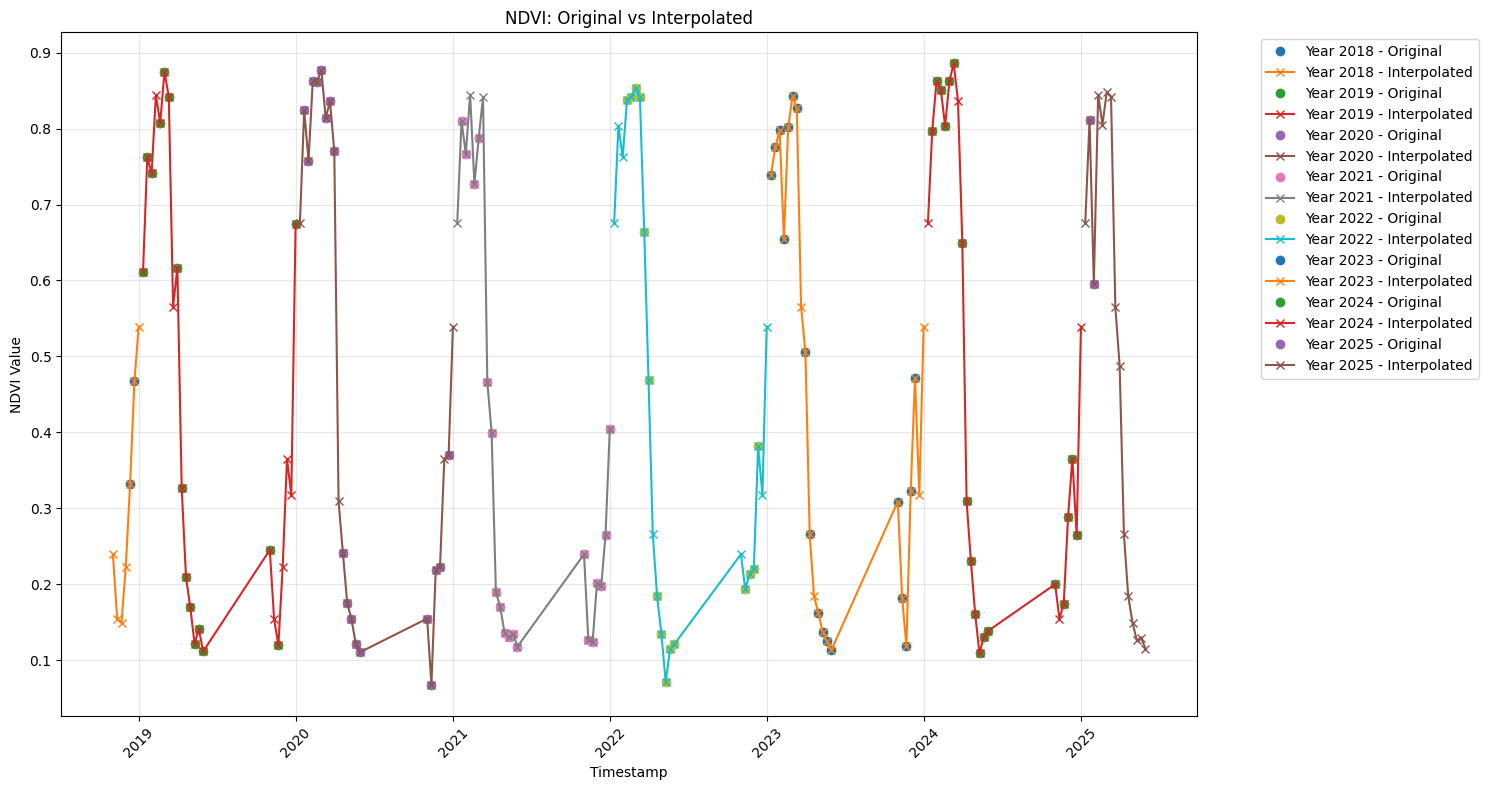

Missing values after interpolation: 0
Total rows in dataset: 154


In [12]:
def interpolate_ndvi(df):
    """
    Interpolate NDVI values with improved seasonal handling and edge cases
    """
    # Create a copy to avoid modifying original data
    df_filtered = df.copy()

    # Convert timestamp to datetime if it isn't already
    df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'])

    # Create seasonal features
    df_filtered['month'] = df_filtered['timestamp'].dt.month
    df_filtered['day'] = df_filtered['timestamp'].dt.day
    df_filtered['day_of_year'] = df_filtered['timestamp'].dt.dayofyear

    # Calculate seasonal medians for each day-month combination
    seasonal_medians = df_filtered.groupby(['month', 'day'])['NDVIi'].transform('median')

    # First pass: Fill missing values with seasonal medians
    df_filtered['NDVIi_interpolated'] = df_filtered['NDVIi'].fillna(seasonal_medians)

    # Second pass: Apply linear interpolation within each year
    for year in df_filtered['year'].unique():
        year_mask = df_filtered['year'] == year
        df_filtered.loc[year_mask, 'NDVIi_interpolated'] = (
            df_filtered.loc[year_mask, 'NDVIi_interpolated']
            .interpolate(method='linear', limit_direction='forward', limit=30)  # Limit to 30 days forward
        )

    # Third pass: Fill any remaining NaN with seasonal patterns
    remaining_nans = df_filtered['NDVIi_interpolated'].isna()
    if remaining_nans.any():
        # Calculate the average NDVI pattern across all years
        seasonal_pattern = (
            df_filtered.groupby('day_of_year')['NDVIi']
            .mean()
            .interpolate(method='cubic')  # Smooth the seasonal pattern
        )

        # Fill remaining NaNs with the seasonal pattern
        for idx in df_filtered[remaining_nans].index:
            day_of_year = df_filtered.loc[idx, 'day_of_year']
            df_filtered.loc[idx, 'NDVIi_interpolated'] = seasonal_pattern[day_of_year]

    # Visualization
    plt.figure(figsize=(15, 8))

    # Plot original and interpolated data by year
    years = df_filtered['year'].unique()
    for year in years:
        year_data = df_filtered[df_filtered['year'] == year]

        plt.plot(year_data['timestamp'], year_data['NDVIi'],
                marker='o', linestyle='', label=f'Year {year} - Original')
        plt.plot(year_data['timestamp'], year_data['NDVIi_interpolated'],
                marker='x', linestyle='-', label=f'Year {year} - Interpolated')

    plt.title('NDVI: Original vs Interpolated')
    plt.xlabel('Timestamp')
    plt.ylabel('NDVI Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return df_filtered

# Usage
result = interpolate_ndvi(result_df)
print("Missing values after interpolation:", result['NDVIi_interpolated'].isna().sum())
print("Total rows in dataset:", len(result))

In [13]:
print(result['NDVIi_interpolated'].isna())

0      False
1      False
2      False
3      False
4      False
       ...  
149    False
150    False
151    False
152    False
153    False
Name: NDVIi_interpolated, Length: 154, dtype: bool


In [14]:
print(result)

     timestamp     NDVIi  year  month  day  day_of_year  NDVIi_interpolated
0   2018-11-01       NaN  2018     11    1          305            0.239632
1   2018-11-11       NaN  2018     11   11          315            0.154452
2   2018-11-21       NaN  2018     11   21          325            0.149620
3   2018-12-01       NaN  2018     12    1          335            0.223541
4   2018-12-11  0.332155  2018     12   11          345            0.332155
..         ...       ...   ...    ...  ...          ...                 ...
149 2025-04-20       NaN  2025      4   20          110            0.184333
150 2025-04-30       NaN  2025      4   30          120            0.149709
151 2025-05-10       NaN  2025      5   10          130            0.126184
152 2025-05-20       NaN  2025      5   20          140            0.129981
153 2025-05-30       NaN  2025      5   30          150            0.115518

[154 rows x 7 columns]


In [15]:
result = result.drop(columns= ['day'])
result = result.drop(columns= ['NDVIi'])
result = result.drop(columns= ['day_of_year'])
print(result)

     timestamp  year  month  NDVIi_interpolated
0   2018-11-01  2018     11            0.239632
1   2018-11-11  2018     11            0.154452
2   2018-11-21  2018     11            0.149620
3   2018-12-01  2018     12            0.223541
4   2018-12-11  2018     12            0.332155
..         ...   ...    ...                 ...
149 2025-04-20  2025      4            0.184333
150 2025-04-30  2025      4            0.149709
151 2025-05-10  2025      5            0.126184
152 2025-05-20  2025      5            0.129981
153 2025-05-30  2025      5            0.115518

[154 rows x 4 columns]


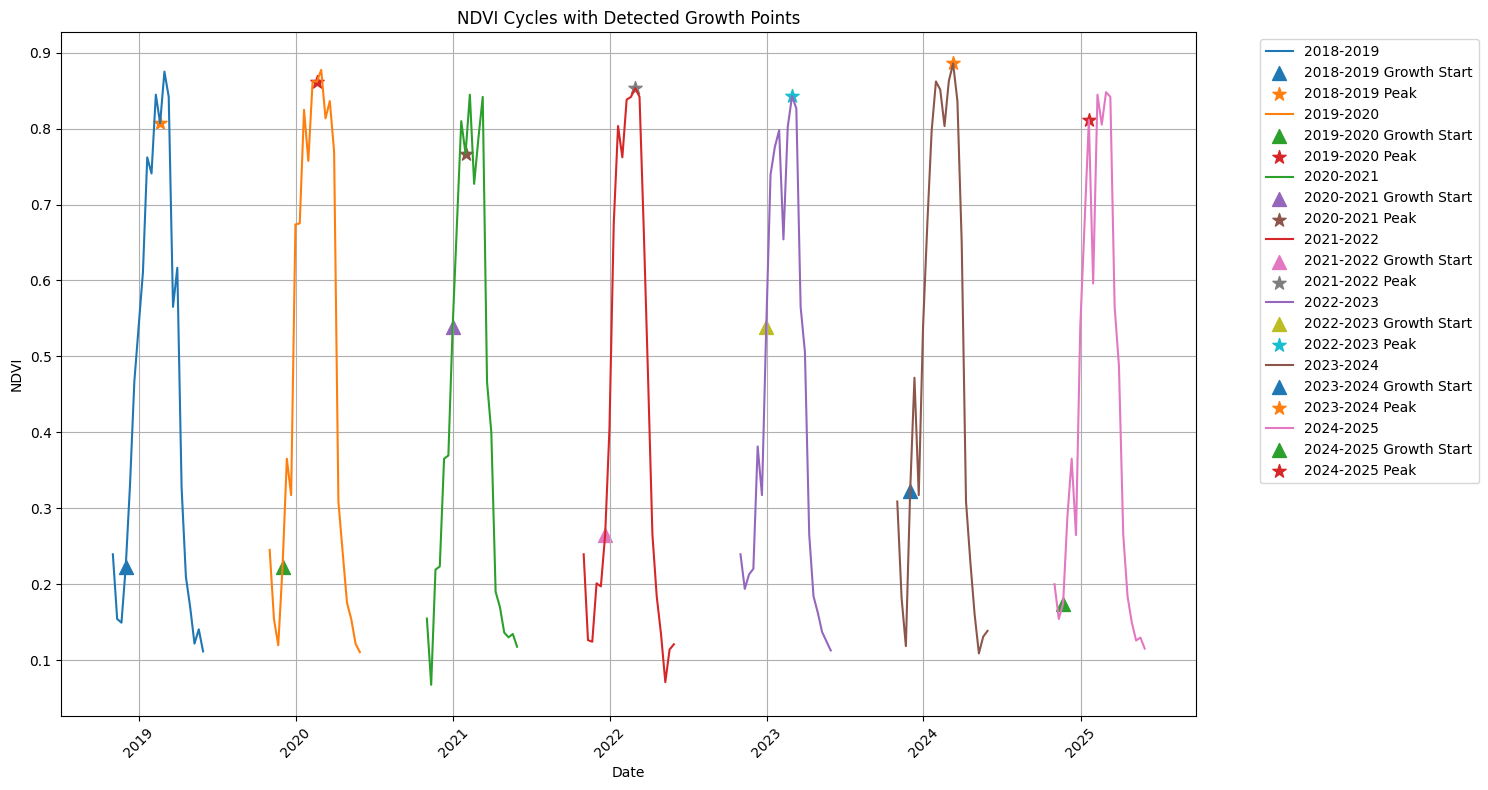


Crop Cycle Analysis with Growth Initiation:
  growing_season sowing_date  sowing_ndvi growth_initiation_date  \
0      2018-2019  2018-11-01     0.239632             2018-12-01   
1      2019-2020  2019-11-01     0.245383             2019-12-01   
2      2020-2021  2020-11-01     0.154984             2020-12-31   
3      2021-2022  2021-11-01     0.239632             2021-12-21   
4      2022-2023  2022-11-01     0.239632             2022-12-31   
5      2023-2024  2023-11-01     0.309054             2023-12-01   
6      2024-2025  2024-11-01     0.200268             2024-11-21   

   growth_initiation_ndvi  peak_date  peak_ndvi  season_length_days  \
0                0.223541 2019-02-19   0.807048                 210   
1                0.223541 2020-02-19   0.861771                 210   
2                0.539310 2021-01-30   0.766848                 210   
3                0.265311 2022-03-01   0.853184                 210   
4                0.539310 2023-03-01   0.842537        

In [16]:
def validate_growth_detection(df, cycles_df, cutoff_date='2025-02-07'):
    """
    Visualize the detected growth points for validation with proper date cutoff

    Parameters:
    - df: DataFrame with NDVI data
    - cycles_df: DataFrame with cycle analysis
    - cutoff_date: Current date to limit the visualization
    """
    plt.figure(figsize=(15, 8))

    cutoff = pd.to_datetime(cutoff_date)

    for _, cycle in cycles_df.iterrows():
        season_start = cycle['sowing_date']
        season_end = min(
            pd.to_datetime(season_start) + pd.Timedelta(days=210),
            cutoff
        )

        # Skip if the entire season is beyond cutoff
        if season_start > cutoff:
            continue

        season_data = df[
            (df['timestamp'] >= season_start) &
            (df['timestamp'] <= season_end)
        ]

        if not season_data.empty:
            plt.plot(season_data['timestamp'], season_data['NDVIi_interpolated'],
                    label=cycle['growing_season'])

            # Only plot points if they're before cutoff
            if cycle['growth_initiation_date'] <= cutoff:
                plt.scatter(cycle['growth_initiation_date'], cycle['growth_initiation_ndvi'],
                          marker='^', s=100, label=f"{cycle['growing_season']} Growth Start")

            if cycle['peak_date'] <= cutoff:
                plt.scatter(cycle['peak_date'], cycle['peak_ndvi'],
                          marker='*', s=100, label=f"{cycle['growing_season']} Peak")

    plt.axvline(x=cutoff, color='r', linestyle='--', label='Current Date')
    plt.title('NDVI Cycles with Detected Growth Points')
    plt.xlabel('Date')
    plt.ylabel('NDVI')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# We should also modify the analyze_crop_cycles function to respect the cutoff date
def analyze_crop_cycles(df, cutoff_date='2025-02-07', min_change=0.02, consecutive_changes=2):
    """
    Analyze crop cycles with proper date cutoff
    """
    cycles = []
    cutoff = pd.to_datetime(cutoff_date)

    for year in df['year'].unique():
        season_start = f"{year}-11-01"
        season_end = min(
            f"{year+1}-05-31",
            cutoff_date
        )

        # Skip if season starts after cutoff
        if pd.to_datetime(season_start) > cutoff:
            continue

        season_data = df[
            (df['timestamp'] >= season_start) &
            (df['timestamp'] <= season_end)
        ].copy()

        if not season_data.empty:
            # Calculate NDVI changes and rolling mean to smooth out noise
            season_data['ndvi_change'] = season_data['NDVIi_interpolated'].diff()
            season_data['ndvi_rolling'] = season_data['NDVIi_interpolated'].rolling(3, center=True).mean()

            # Find growth initiation using multiple methods
            growth_start_idx = None

            # Method 1: Look for consecutive positive changes
            for i in range(len(season_data) - consecutive_changes + 1):
                if (season_data['ndvi_change'].iloc[i:i+consecutive_changes] > min_change).all():
                    growth_start_idx = i
                    break

            # Method 2: If Method 1 fails, look for significant absolute increase
            if growth_start_idx is None:
                baseline = season_data['NDVIi_interpolated'].iloc[0:3].mean()
                for i in range(len(season_data)):
                    if season_data['NDVIi_interpolated'].iloc[i] > (baseline + 0.1):  # 0.1 threshold
                        growth_start_idx = i
                        break

            # Method 3: If both methods fail, use the point of maximum rate of change
            if growth_start_idx is None:
                growth_start_idx = season_data['ndvi_change'].idxmax()

            # Find peak NDVI
            peak_idx = season_data['ndvi_rolling'].idxmax()
            peak_row = season_data.loc[peak_idx]

            # Get sowing period
            sowing_period = season_data[
                season_data['timestamp'].dt.month == 11
            ].iloc[0]

            # Get growth initiation data
            growth_initiation = season_data.iloc[growth_start_idx]['timestamp']
            growth_ndvi = season_data.iloc[growth_start_idx]['NDVIi_interpolated']

            cycles.append({
                'growing_season': f"{year}-{year+1}",
                'sowing_date': sowing_period['timestamp'],
                'sowing_ndvi': sowing_period['NDVIi_interpolated'],
                'growth_initiation_date': growth_initiation,
                'growth_initiation_ndvi': growth_ndvi,
                'peak_date': peak_row['timestamp'],
                'peak_ndvi': peak_row['NDVIi_interpolated'],
                'season_length_days': (season_data.iloc[-1]['timestamp'] - sowing_period['timestamp']).days,
                'sowing_to_growth_days': (growth_initiation - sowing_period['timestamp']).days,
                'growth_to_peak_days': (peak_row['timestamp'] - growth_initiation).days
            })

    return pd.DataFrame(cycles)

# Function to validate and visualize the growth detection
def validate_growth_detection(df, cycles_df):
    """Visualize the detected growth points for validation"""
    plt.figure(figsize=(15, 8))

    for _, cycle in cycles_df.iterrows():
        season_start = cycle['sowing_date']
        season_end = pd.to_datetime(season_start) + pd.Timedelta(days=210)

        season_data = df[
            (df['timestamp'] >= season_start) &
            (df['timestamp'] <= season_end)
        ]

        plt.plot(season_data['timestamp'], season_data['NDVIi_interpolated'],
                label=cycle['growing_season'])

        # Plot growth initiation points
        plt.scatter(cycle['growth_initiation_date'], cycle['growth_initiation_ndvi'],
                   marker='^', s=100, label=f"{cycle['growing_season']} Growth Start")

        # Plot peak points
        plt.scatter(cycle['peak_date'], cycle['peak_ndvi'],
                   marker='*', s=100, label=f"{cycle['growing_season']} Peak")

    plt.title('NDVI Cycles with Detected Growth Points')
    plt.xlabel('Date')
    plt.ylabel('NDVI')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Usage
cycles = analyze_crop_cycles(result, min_change=0.015, consecutive_changes=2)
validate_growth_detection(result, cycles)

print("\nCrop Cycle Analysis with Growth Initiation:")
print(cycles)


In [17]:

cycles = cycles.drop(6)  # 2025 season is not still completed , incomplete data can cause deviation in mean values


In [18]:
sowing_period_time = cycles['sowing_to_growth_days'].sum()
total_years = 6
avg_sowing_period = sowing_period_time / total_years
print(f"Average sowing period: {avg_sowing_period:.2f} days")

Average sowing period: 43.33 days


In [19]:
growth_period_time = cycles['growth_to_peak_days'].sum()
total_years = 6
avg_growth_period = growth_period_time / total_years
avg_growth_period += avg_sowing_period
print(f"Average growth period: {avg_growth_period:.2f} days")

Average growth period: 113.33 days


In [20]:
harvest_period_time = cycles['season_length_days'].sum()
total_years = 6
avg_harvest_period = harvest_period_time / total_years
avg_harvest_period -= 30       # We are considering april as harvesting time period
print(f"Average harvest period: {avg_harvest_period:.2f} days")

Average harvest period: 180.00 days


In [21]:
threshold_ndvi = cycles['growth_initiation_ndvi'].mean()
print(f"Threshold NDVI for growth initiation: {threshold_ndvi:.3f}")

Threshold NDVI for growth initiation: 0.352


In [22]:
peak_ndvi = cycles['peak_ndvi'].max()                           ## yield pred can tell us what will be best way to select peak NDVI value
print(f"Peak NDVI for peak: {peak_ndvi:.3f}")

Peak NDVI for peak: 0.886


In [23]:
min_ndvi = cycles['sowing_ndvi'].mean()
print(f"Minimum NDVI for sowing: {min_ndvi:.3f}")

Minimum NDVI for sowing: 0.238


In [24]:
active_growth_ndvi = threshold_ndvi + (peak_ndvi - threshold_ndvi) / 2
print(f"Active growth NDVI: {active_growth_ndvi:.3f}")

Active growth NDVI: 0.619


In [25]:
print("NDVI Data Statistics:")
print(result['NDVIi_interpolated'].describe())
print("\nStandard Deviation:", result['NDVIi_interpolated'].std())

NDVI Data Statistics:
count    154.000000
mean       0.443404
std        0.283553
min        0.067801
25%        0.175022
50%        0.348792
75%        0.762105
max        0.885730
Name: NDVIi_interpolated, dtype: float64

Standard Deviation: 0.2835525023457151


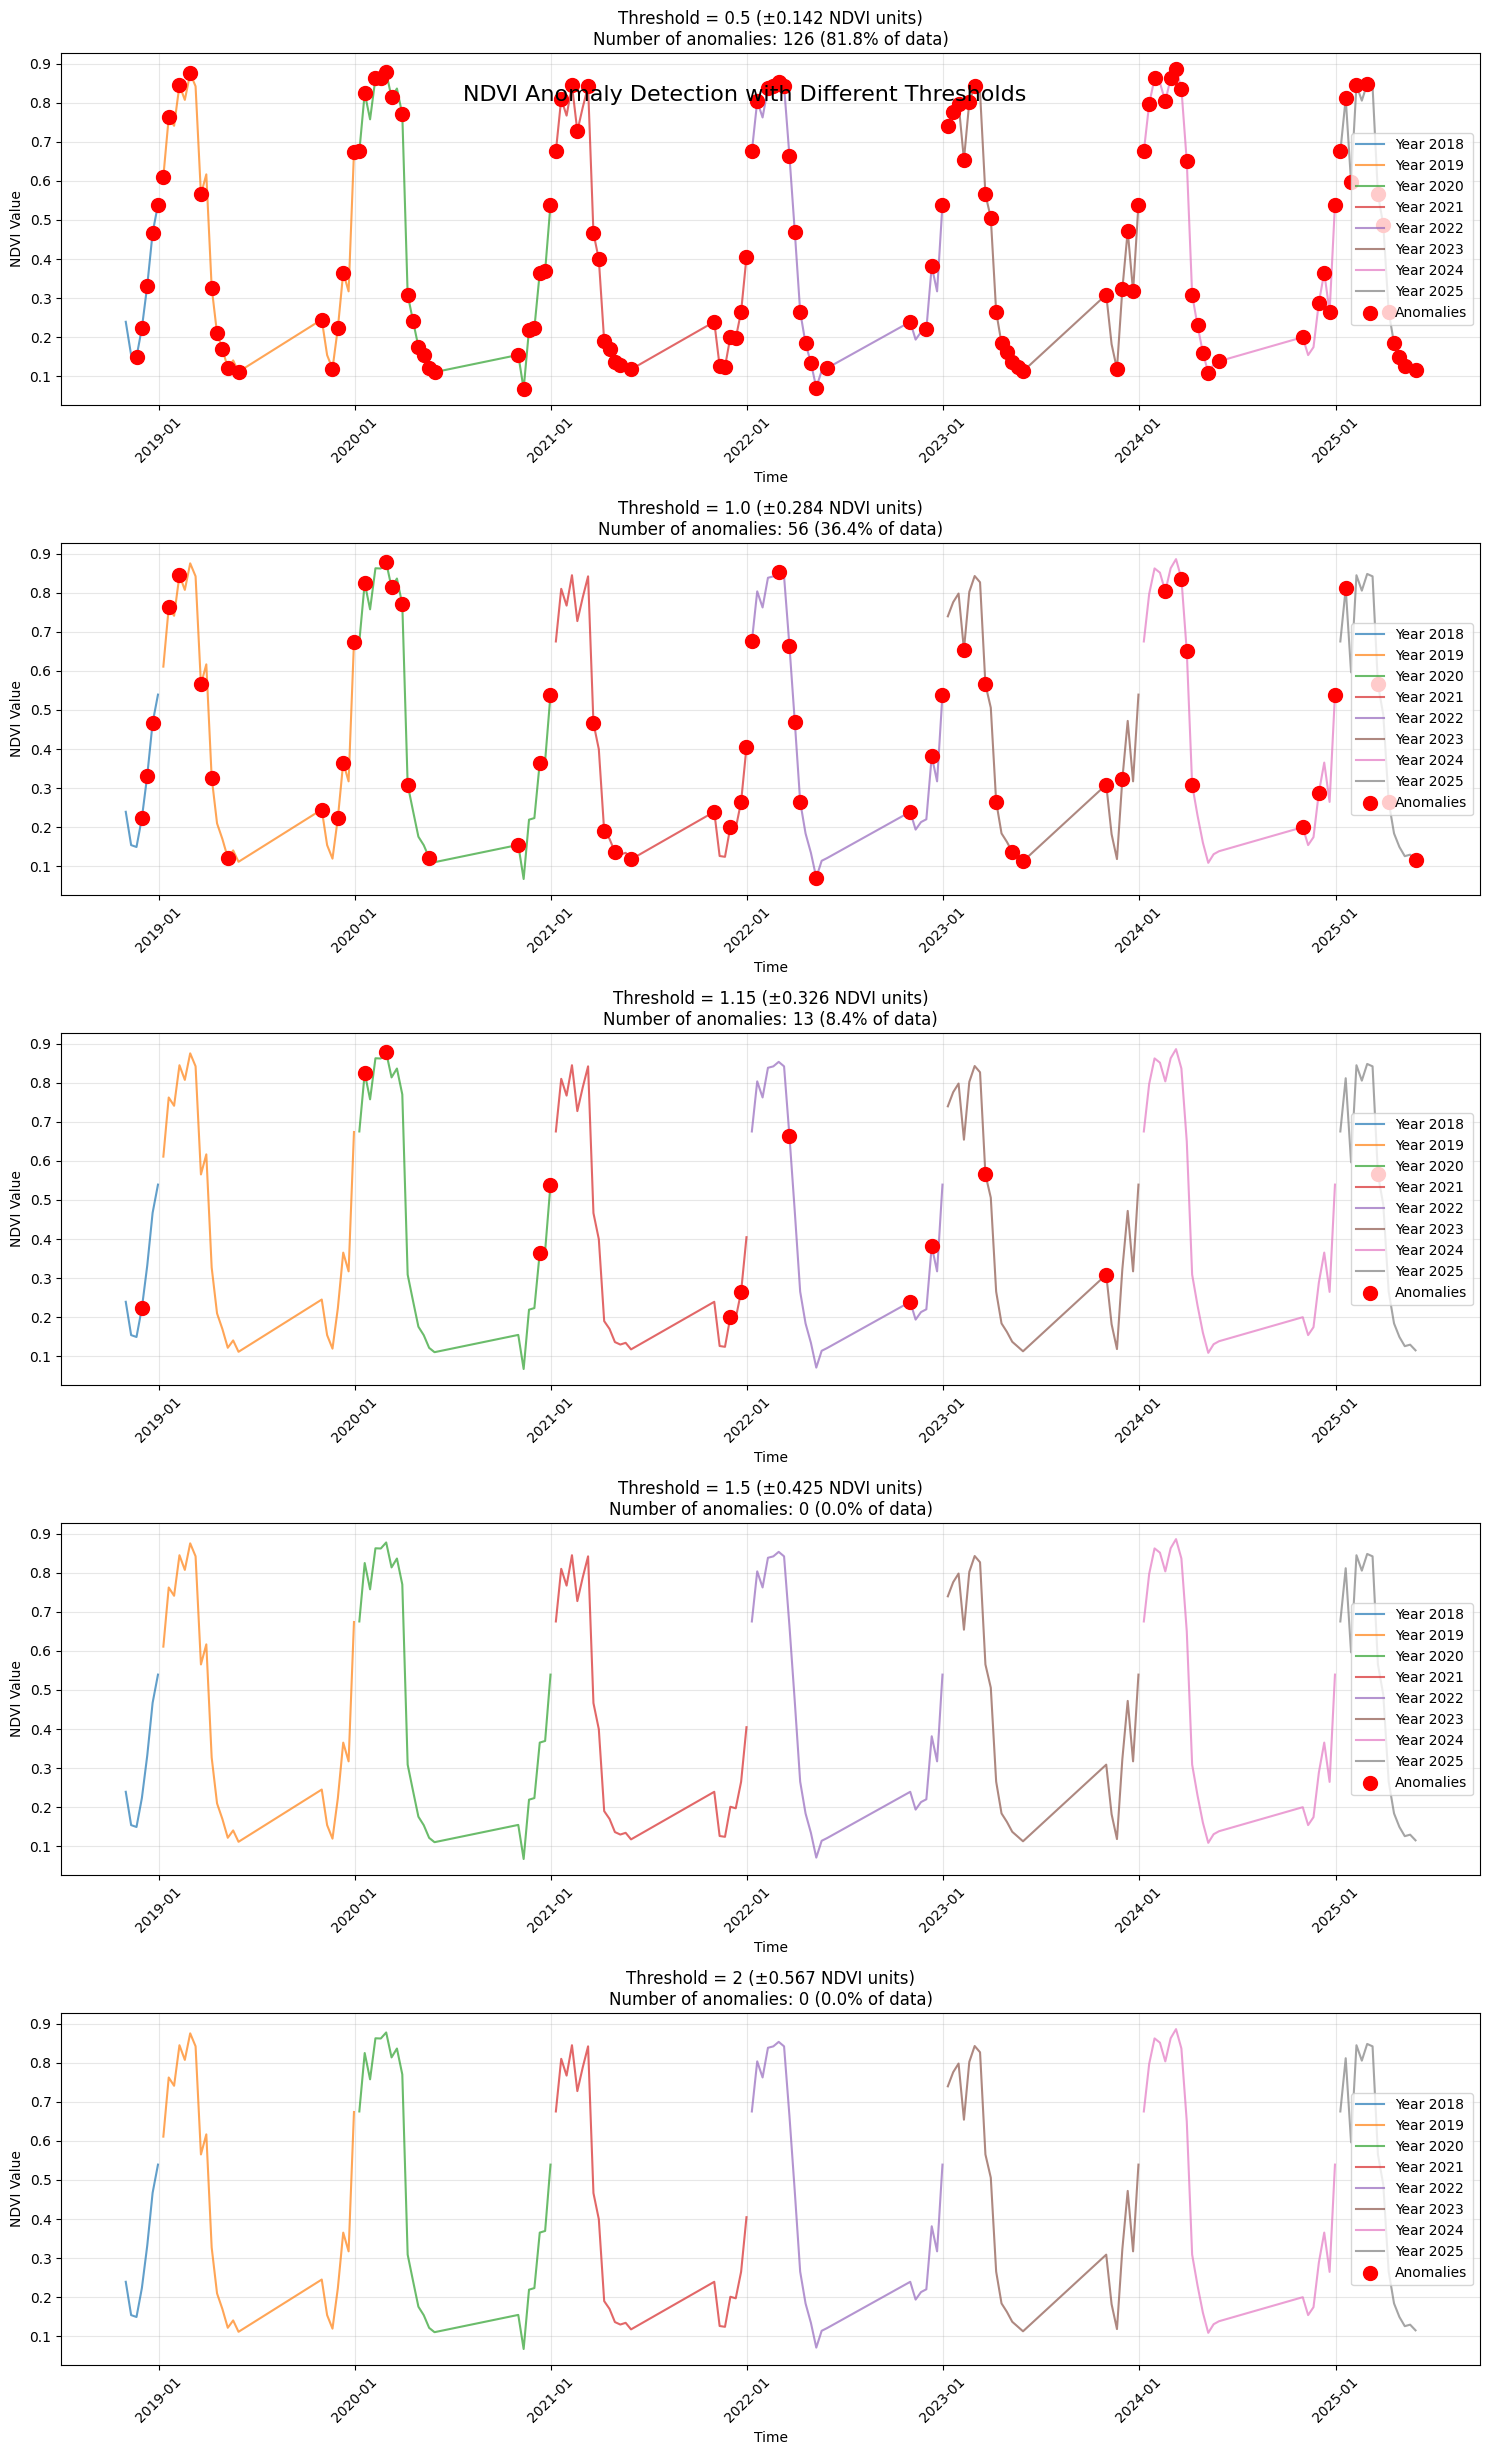


Detailed Threshold Analysis:
---------------------------

Threshold: 0.5
Allowed deviation: ±0.142 NDVI units
Number of anomalies: 126.0
Percentage of data flagged: 81.8%
Interpretation: Too sensitive

Threshold: 1.0
Allowed deviation: ±0.284 NDVI units
Number of anomalies: 56.0
Percentage of data flagged: 36.4%
Interpretation: Too sensitive

Threshold: 1.15
Allowed deviation: ±0.326 NDVI units
Number of anomalies: 13.0
Percentage of data flagged: 8.4%
Interpretation: Good sensitivity

Threshold: 1.5
Allowed deviation: ±0.425 NDVI units
Number of anomalies: 0.0
Percentage of data flagged: 0.0%
Interpretation: May miss anomalies

Threshold: 2.0
Allowed deviation: ±0.567 NDVI units
Number of anomalies: 0.0
Percentage of data flagged: 0.0%
Interpretation: May miss anomalies

NDVI Data Distribution:
----------------------
count    154.000000
mean       0.443404
std        0.283553
min        0.067801
25%        0.175022
50%        0.348792
75%        0.762105
max        0.885730
Name: NDV

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

def analyze_threshold_impacts(df, thresholds=[0.5, 1.0, 1.15, 1.5, 2]):
    std_dev = df['NDVIi_interpolated'].std()
    window_size = 3

    # Create figure
    fig, axs = plt.subplots(len(thresholds), 1, figsize=(15, 5*len(thresholds)))
    fig.suptitle('NDVI Anomaly Detection with Different Thresholds', fontsize=16, y=0.95)

    results = []

    for idx, threshold in enumerate(thresholds):
        # Calculate rolling statistics
        rolling_mean = df['NDVIi_interpolated'].rolling(window=window_size).mean()
        rolling_std = df['NDVIi_interpolated'].rolling(window=window_size).std()

        # Define bounds
        upper_bound = rolling_mean + (threshold * rolling_std)
        lower_bound = rolling_mean - (threshold * rolling_std)

        # Detect anomalies
        anomalies = df[
            (df['NDVIi_interpolated'] > upper_bound) |
            (df['NDVIi_interpolated'] < lower_bound)
        ]

        # Calculate actual deviation range
        actual_deviation = threshold * std_dev

        # Store results
        results.append({
            'threshold': threshold,
            'num_anomalies': len(anomalies),
            'percentage': (len(anomalies) / len(df)) * 100,
            'deviation_range': actual_deviation
        })

        # Plot
        ax = axs[idx]

        # Plot original NDVI
        for year in df['year'].unique():
            year_data = df[df['year'] == year]
            ax.plot(year_data['timestamp'], year_data['NDVIi_interpolated'],
                   label=f'Year {year}', alpha=0.7)

        # Plot anomalies
        ax.scatter(anomalies['timestamp'], anomalies['NDVIi_interpolated'],
                  color='red', s=100, label='Anomalies', zorder=5)

        ax.set_title(f'Threshold = {threshold} (±{actual_deviation:.3f} NDVI units)\n'
                    f'Number of anomalies: {len(anomalies)} ({(len(anomalies)/len(df)*100):.1f}% of data)')
        ax.set_xlabel('Time')
        ax.set_ylabel('NDVI Value')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Format dates
        ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

    # Print detailed analysis
    results_df = pd.DataFrame(results)
    print("\nDetailed Threshold Analysis:")
    print("---------------------------")
    for _, row in results_df.iterrows():
        print(f"\nThreshold: {row['threshold']}")
        print(f"Allowed deviation: ±{row['deviation_range']:.3f} NDVI units")
        print(f"Number of anomalies: {row['num_anomalies']}")
        print(f"Percentage of data flagged: {row['percentage']:.1f}%")
        print(f"Interpretation: {'Too sensitive' if row['percentage'] > 20 else 'Good sensitivity' if 5 <= row['percentage'] <= 20 else 'May miss anomalies'}")

# Run the analysis
analyze_threshold_impacts(result)

# Print basic NDVI statistics for reference
print("\nNDVI Data Distribution:")
print("----------------------")
stats = result['NDVIi_interpolated'].describe()
print(stats)
print(f"\nStandard Deviation: {result['NDVIi_interpolated'].std():.3f}")

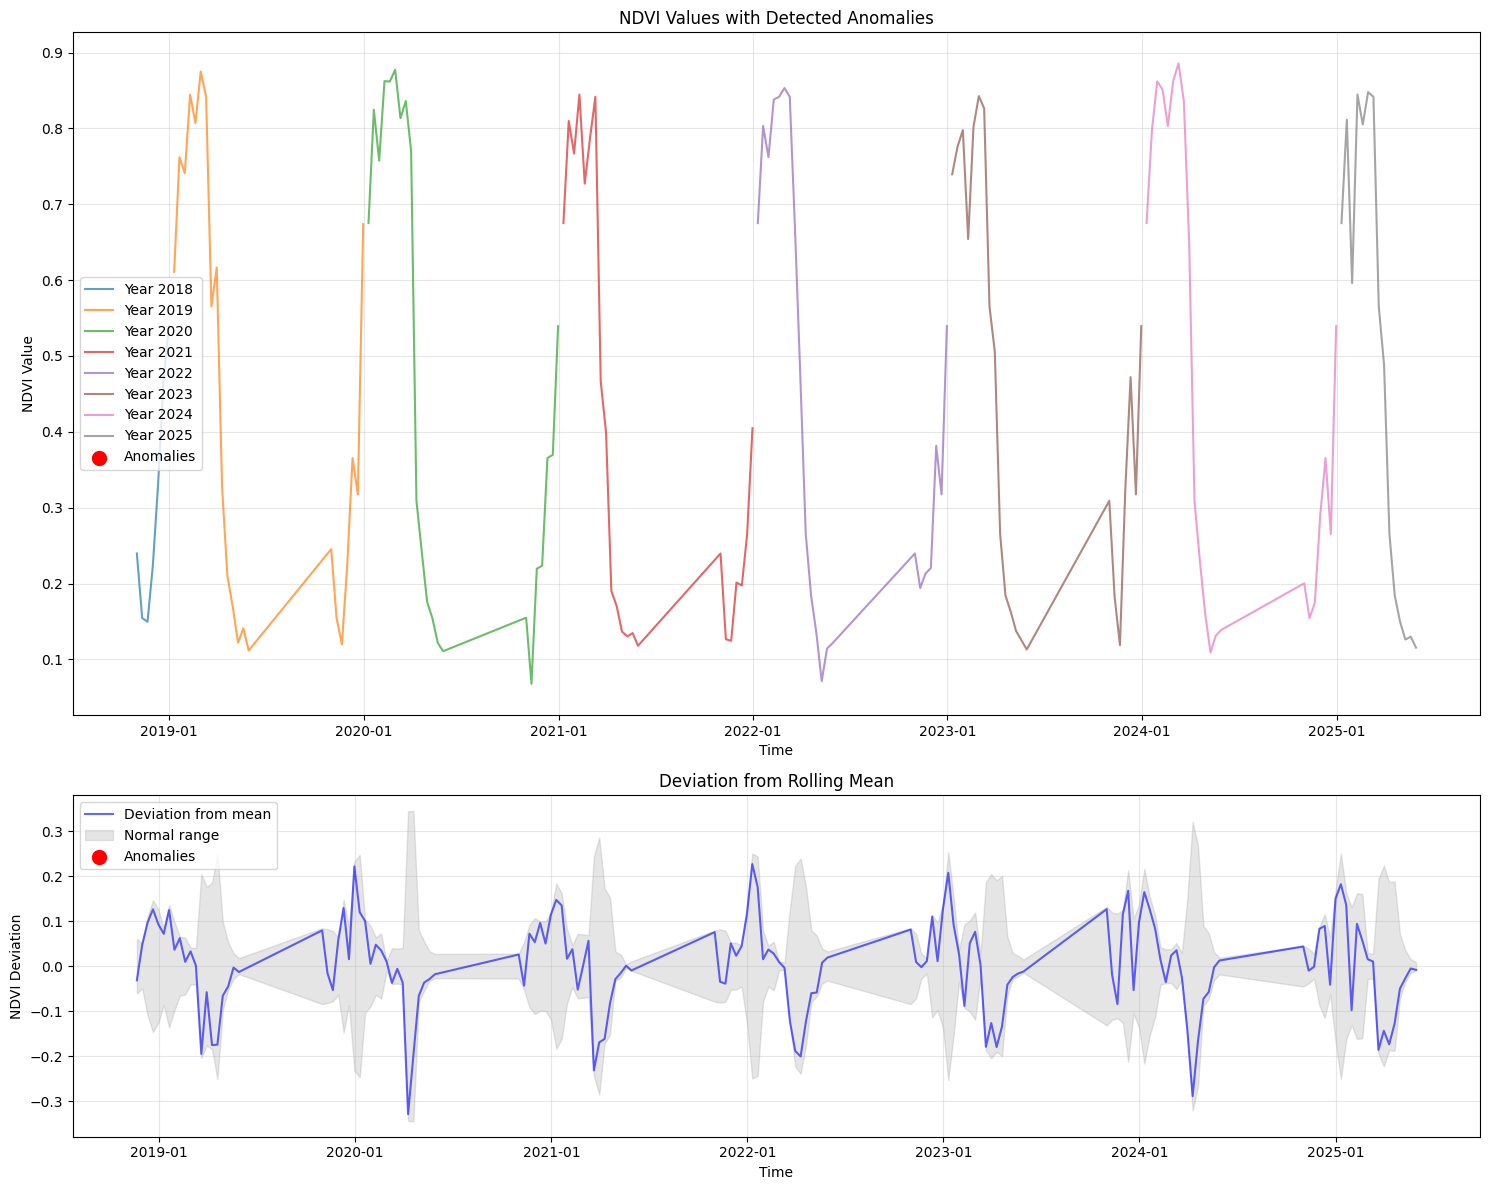


Anomaly Statistics:
Total number of anomalies detected: 0


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

def detect_and_plot_anomalies(df, window_size=3, std_threshold = 1.2):
    # Calculate rolling statistics
    rolling_mean = df['NDVIi_interpolated'].rolling(window=window_size).mean()
    rolling_std = df['NDVIi_interpolated'].rolling(window=window_size).std()

    # Define upper and lower bounds
    upper_bound = rolling_mean + (std_threshold * rolling_std)
    lower_bound = rolling_mean - (std_threshold * rolling_std)

    # Detect anomalies
    anomalies = df[
        (df['NDVIi_interpolated'] > upper_bound) |
        (df['NDVIi_interpolated'] < lower_bound)
    ]

    # Create the visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[2, 1])

    # Plot 1: Original NDVI with anomalies
    for year in df['year'].unique():
        year_data = df[df['year'] == year]
        ax1.plot(year_data['timestamp'], year_data['NDVIi_interpolated'],
                 label=f'Year {year}', alpha=0.7)

    # Highlight anomalies
    ax1.scatter(anomalies['timestamp'], anomalies['NDVIi_interpolated'],
                color='red', s=100, label='Anomalies', zorder=5)

    ax1.set_title('NDVI Values with Detected Anomalies')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('NDVI Value')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Deviation from rolling mean
    deviation = df['NDVIi_interpolated'] - rolling_mean
    ax2.plot(df['timestamp'], deviation, label='Deviation from mean', color='blue', alpha=0.6)
    ax2.fill_between(df['timestamp'],
                     -std_threshold * rolling_std,
                     std_threshold * rolling_std,
                     color='gray', alpha=0.2, label='Normal range')

    # Highlight anomalous deviations
    anomalous_deviations = deviation[
        (df['NDVIi_interpolated'] > upper_bound) |
        (df['NDVIi_interpolated'] < lower_bound)
    ]
    ax2.scatter(anomalous_deviations.index,
                anomalous_deviations.values,
                color='red', s=100, label='Anomalies', zorder=5)

    ax2.set_title('Deviation from Rolling Mean')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('NDVI Deviation')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Format dates on x-axis
    date_formatter = DateFormatter("%Y-%m")
    ax1.xaxis.set_major_formatter(date_formatter)
    ax2.xaxis.set_major_formatter(date_formatter)

    plt.tight_layout()
    plt.show()

    # Print anomaly statistics
    print("\nAnomaly Statistics:")
    print(f"Total number of anomalies detected: {len(anomalies)}")
    if not anomalies.empty:
          print("\nAnomalous dates and values:")
    for idx, row in anomalies.iterrows():
        print(f"Date: {row['timestamp'].strftime('%Y-%m-%d')}, "
              f"NDVI: {row['NDVIi_interpolated']:.3f}")

    return anomalies

# Use the function
anomalies = detect_and_plot_anomalies(result)

In [28]:
result_df

,timestamp,NDVIi,year,month
0,2018-11-01,NaN,2018,11
1,2018-11-11,NaN,2018,11
2,2018-11-21,NaN,2018,11
3,2018-12-01,NaN,2018,12
4,2018-12-11,0.332155,2018,12
...,...,...,...,...
149,2025-04-20,NaN,2025,4
150,2025-04-30,NaN,2025,4
151,2025-05-10,NaN,2025,5
152,2025-05-20,NaN,2025,5


In [69]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from datetime import timedelta

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def prepare_data(df, seq_length=6):
    train_data = df[df['year'] < 2024]['NDVIi_interpolated'].values
    test_data = df[df['year'] >= 2024]['NDVIi_interpolated'].values
    test_dates = df[df['year'] >= 2024]['timestamp'].values  # Get test set dates

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))

    X_train, y_train = create_sequences(train_scaled, seq_length)
    X_test, y_test = create_sequences(test_scaled, seq_length)

    return X_train, y_train, X_test, y_test, scaler, test_dates[-1]

def build_lstm_model(seq_length):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

def evaluate_predictions(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # Calculate accuracy as 1 - normalized RMSE
    accuracy = 1 - (rmse / (np.max(y_true) - np.min(y_true)))

    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Accuracy': accuracy
    }

def plot_results(actual, predicted, title='NDVI Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual', marker='o')
    plt.plot(predicted, label='Predicted', marker='x')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('NDVI')
    plt.legend()
    plt.grid(True)
    plt.show()

# Predict next 10 days NDVI

def predict_next_10_days(model, last_sequence, scaler, last_date):
    predictions = []
    dates = []
    input_seq = last_sequence.copy()

    for i in range(1):  # Predict for next 10 days which will be calculted to give as a new predicted ndvi composite
        pred = model.predict(input_seq.reshape(1, -1, 1))
        pred_inv = scaler.inverse_transform(pred)
        predictions.append(pred_inv[0][0])

        # Convert last_date to datetime if needed
        last_date = pd.to_datetime(last_date)
        dates.append(last_date + timedelta(days=i + 1))  # Generate future timestamps

        input_seq = np.append(input_seq[1:], pred)

    return predictions, dates


# Main execution
def train_and_evaluate(df):
    # Prepare data
    X_train, y_train, X_test, y_test, scaler,last_test_date = prepare_data(df)

    # Build and train model
    model = build_lstm_model(X_train.shape[1])
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Inverse transform predictions
    train_pred = scaler.inverse_transform(train_pred)
    test_pred = scaler.inverse_transform(test_pred)
    y_train_orig = scaler.inverse_transform(y_train)
    y_test_orig = scaler.inverse_transform(y_test)

    # Evaluate model
    train_metrics = evaluate_predictions(y_train_orig, train_pred)
    test_metrics = evaluate_predictions(y_test_orig, test_pred)

    # Plot results
    plot_results(y_test_orig, test_pred, 'NDVI Predictions for 2024 (Test Set)')

    # Predict next 10 days NDVI
    last_sequence = X_test[-1]  # Get last sequence from test data
    next_10_days_predictions, next_10_days_dates = predict_next_10_days(model, last_sequence, scaler, last_test_date)

    global global_next_10_days_prediction
    global_next_10_days_prediction = list(zip(next_10_days_dates, next_10_days_predictions))

    print("Next 10 Days NDVI Predictions:", next_10_days_predictions)

    return train_metrics, test_metrics, model


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - loss: 0.3456 - val_loss: 0.3002
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2934 - val_loss: 0.2734
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2759 - val_loss: 0.2434
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2562 - val_loss: 0.2113
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2445 - val_loss: 0.1797
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1826 - val_loss: 0.1489
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1596 - val_loss: 0.1207
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1371 - val_loss: 0.1007
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1193 - val_loss: 0.0952
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1181 - val_loss: 0.0972
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1065 - val_loss: 0.0967
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1033 - val_loss: 0.0931

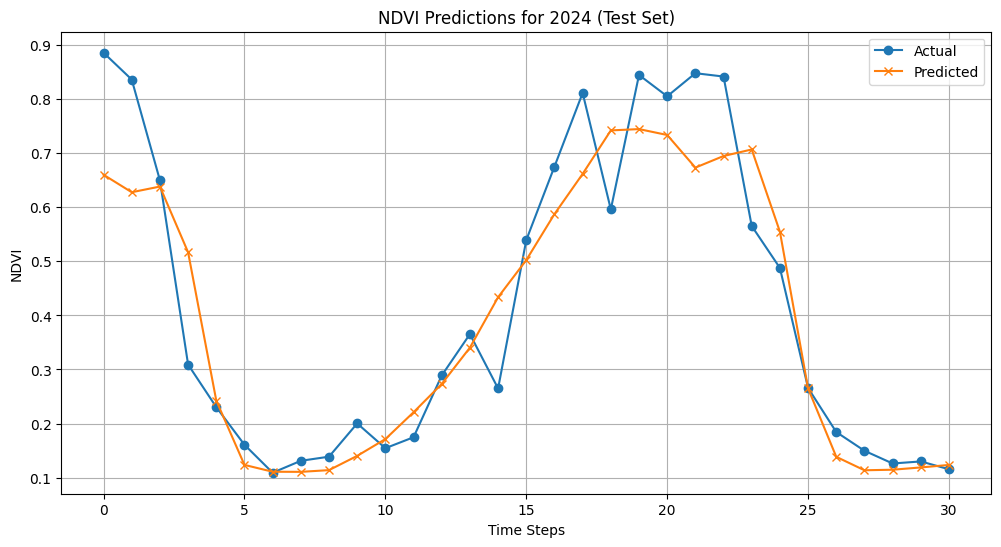

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Next 10 Days NDVI Predictions: [0.123494565]

Training Metrics: {'RMSE': 0.09148550061127345, 'MAE': 0.07133695016067551, 'R2': 0.8937649011590172, 'Accuracy': 0.8869720605803881}

Test Metrics: {'RMSE': 0.1021910568153096, 'MAE': 0.07476106277541879, 'R2': 0.8670101899493452, 'Accuracy': 0.8684148043974206}


In [70]:
train_metrics, test_metrics, model = train_and_evaluate(result)
print("\nTraining Metrics:", train_metrics)
print("\nTest Metrics:", test_metrics)

In [71]:
global_next_10_days_prediction

[(Timestamp('2025-05-31 00:00:00'), 0.123494565)]

In [74]:
pred_timestamp , ndvi_prediction = global_next_10_days_prediction[0]


In [31]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Load NDWI predictions
ndwi_predictions = pd.read_csv('/content/drive/My Drive/NDWI_predictions.csv')

# Now use ndwi_predictions for further analysis
print(ndwi_predictions)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
         Date  Predicted_NDWI
0  2025-05-31       -0.232355


In [33]:
## Feature Engg and Data Cleaning -> Try adv techniques

In [34]:
## Weather prediction to make preventions from damage -> Weather Variables

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load and print results
file_path = "/content/drive/My Drive/NDWI_results.txt"
with open(file_path, "r") as file:
    results = file.read()

print("Loaded NDWI Results:\n")
print(results)


Mounted at /content/drive
Loaded NDWI Results:

Average sowing period: 43.33 days
Active NDWI: -0.605
Average growth period: 125.00 days
Average harvest period: 180.00 days
Threshold NDWI for growth initiation: -0.328
Peak NDWI for peak: -0.756
Minimum NDWI for sowing: -0.311



In [6]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Load NDWI predictions
ndwi_predictions_dataset = pd.read_csv('/content/drive/My Drive/NDWI_predictions.csv')

ndwi_prediction = ndwi_predictions_dataset['Predicted_NDWI']
pred_timestamp = ndwi_predictions_dataset['Date']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
average_sowing_period_ndwi = 43.33
average_growth_period_ndwi = 125.00
average_harvest_period = 180.00
threshold_ndwi_for_growth_initiation = -0.328
peak_ndwi_for_peak = -0.756
minimum_ndwi_for_sowing = -0.311
active_growth_ndwi = -0.605

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Thresholds from historical data
THRESHOLDS = {
    'minimal_growth': min_ndvi,
    'growth_initiation': threshold_ndvi,
    'active_growth': active_growth_ndvi,
    'peak_growth': peak_ndvi
}

# Define seasonal growth stages (months)
SEASONS = {
    'sowing': [11],
    'growth_initiation': [12, 1],
    'peak_time': [1, 2],
    'just_before_harvest': [3],
    'harvest': [4]
}

# Function to analyze NDVI predictions
def analyze_predictions(predictions, dates):
    analysis_results = []

    for pred, date in zip(predictions, dates):
        month = date.month
        status = {}
        status['date'] = date.strftime('%Y-%m-%d')
        status['predicted_ndvi'] = round(pred, 3)

        # 🚜 Condition: If the date is outside the farming season
        if month not in sum(SEASONS.values(), []):
            status['condition'] = 'OUT OF SEASON'
            status['reason'] = (
                "🚜 It's not the farming season right now. Take a break and plan ahead!"
            )
            analysis_results.append(status)
            continue

        # 🚨 Condition 1: Severe Crop Stress (Drought, Pests, or Disease)
        if pred < THRESHOLDS['minimal_growth']:
            status['condition'] = 'CRITICAL'
            status['reason'] = (
                "NDVI is below the minimum threshold. 🚨 Immediate action needed! "
                "Possible causes: Severe water stress (drought), pest infestation, "
                "disease outbreak, or complete crop failure. Farmers should check irrigation, "
                "apply pest control, and inspect crops for diseases."
            )
            analysis_results.append(status)
            continue

        # ✅ Condition 2: Healthy Growth (Ideal for the Current Stage)
        if pred > THRESHOLDS['active_growth']:
            if month in SEASONS['growth_initiation'] + SEASONS['just_before_harvest']:
                if month in SEASONS['peak_time'] and pred < 0.80:
                    status['condition'] = 'NOT SO GOOD'
                    status['reason'] = (
                        "NDVI is lower than expected during peak growth. 🌱 This might indicate "
                        "delayed growth, nutrient deficiency, or mild water stress. "
                        "Farmers should check soil nutrients and irrigation schedules."
                    )
                else:
                    status['condition'] = 'HEALTHY'
                    status['reason'] = (
                        "NDVI indicates strong crop growth for this period. 🌿 Keep monitoring "
                        "soil moisture and nutrients to maintain optimal growth."
                    )

        # ⚠️ Condition 3: Moderate Growth (Potential Issues)
        elif THRESHOLDS['growth_initiation'] < pred <= THRESHOLDS['active_growth']:
            if month in SEASONS['peak_time'] or month in SEASONS['sowing'] or month in SEASONS['harvest']:
                status['condition'] = 'WARNING'
                status['reason'] = (
                    "NDVI is too low for this period. 🌾 Possible causes: Stunted growth, poor germination, "
                    "nutrient deficiency, or early senescence. Farmers should apply fertilizers, "
                    "check pest infestation, and monitor for any environmental stress."
                )
            else:
                status['condition'] = 'MODERATE'
                status['reason'] = (
                    "NDVI suggests normal growth, but it's not optimal. 🚜 Farmers should ensure proper "
                    "irrigation and fertilizer use for better crop health."
                )

        # 🌾 Condition 4: Pre-Harvest or Sowing Stage (Low NDVI is Expected)
        elif pred <= THRESHOLDS['growth_initiation']:
            if month in SEASONS['sowing'] or month in SEASONS['harvest']:
                status['condition'] = 'EXPECTED'
                status['reason'] = (
                    "NDVI is low, but this is normal for the sowing or harvest period. 🌾 No immediate "
                    "action needed, but monitor closely for any unexpected decline."
                )
            else:
                status['condition'] = 'BAD'
                status['reason'] = (
                    "NDVI is too low for this growth period. 🌱 This might indicate poor establishment, "
                    "severe stress, or crop damage. Farmers should inspect fields and apply necessary interventions."
                )

        # 🔥 Condition 5: Drought Stress Detection
        if pred < 0.35 and month in SEASONS['growth_initiation'] + SEASONS['peak_time']:
            status['additional_warning'] = "Drought Stress Detected"
            status['suggestion'] = (
                "⚠️ NDVI suggests possible drought conditions. Farmers should increase irrigation, "
                "check soil moisture, and avoid excessive fertilization."
            )

        # 🦟 Condition 6: Pest Infestation Warning
        if pred < 0.40 and month in SEASONS['growth_initiation'] and pred < (THRESHOLDS['growth_initiation'] + 0.05):
            status['additional_warning'] = "Pest Infestation Possible"
            status['suggestion'] = (
                "⚠️ NDVI suggests potential pest damage. Farmers should inspect fields for pest signs, "
                "use eco-friendly pesticides, and monitor for further decline."
            )

        # 🦠 Condition 7: Disease Detection
        if pred > 0.55 and month in SEASONS['growth_initiation'] and pred < (THRESHOLDS['peak_growth'] - 0.10):
            status['additional_warning'] = "Disease Symptoms Detected"
            status['suggestion'] = (
                "⚠️ NDVI suggests early-stage disease symptoms. Farmers should check leaves for fungal/bacterial infections, "
                "apply fungicides if needed, and avoid water stagnation."
            )

        analysis_results.append(status)

    return pd.DataFrame(analysis_results)


# Visualization Function
def visualize_predictions(analysis_df):
    plt.figure(figsize=(12, 6))

    # Define color mapping for conditions
    color_map = {
        'HEALTHY': 'green',
        'EXPECTED': 'blue',
        'MODERATE': 'orange',
        'WARNING': 'darkorange',
        'NOT SO GOOD': 'red',
        'BAD': 'brown',
        'CRITICAL': 'black'
    }

    # Plot points with colors based on condition
    for condition in color_map.keys():
        mask = analysis_df['condition'] == condition
        if mask.any():
            plt.scatter(pd.to_datetime(analysis_df[mask]['date']),
                        analysis_df[mask]['predicted_ndvi'],
                        label=condition,
                        color=color_map[condition])

    plt.plot(pd.to_datetime(analysis_df['date']),
             analysis_df['predicted_ndvi'],
             'b--', alpha=0.5)

    plt.title('NDVI Predictions for Next 10 Days')
    plt.xlabel('Date')
    plt.ylabel('NDVI')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Run Analysis
def run_prediction_analysis(predictions, dates):
    """
    Run the complete prediction and analysis pipeline
    """
    analysis_df = analyze_predictions(predictions, dates)

    print("\nPrediction Analysis Results:")
    print("=" * 80)
    for _, row in analysis_df.iterrows():
        print(f"\nDate: {row['date']}")
        print(f"Predicted NDVI: {row['predicted_ndvi']}")
        print(f"Condition: {row['condition']}")
        print(f"Reason: {row['reason']}")
        if 'additional_warning' in row:
            print(f"⚠ {row['additional_warning']}: {row['suggestion']}")

    visualize_predictions(analysis_df)
    return analysis_df



Prediction Analysis Results:

Date: 2025-05-31
Predicted NDVI: 0.12300000339746475
Condition: OUT OF SEASON
Reason: 🚜 It's not the farming season right now. Take a break and plan ahead!


<ipython-input-75-10a6d12640e6>:161: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


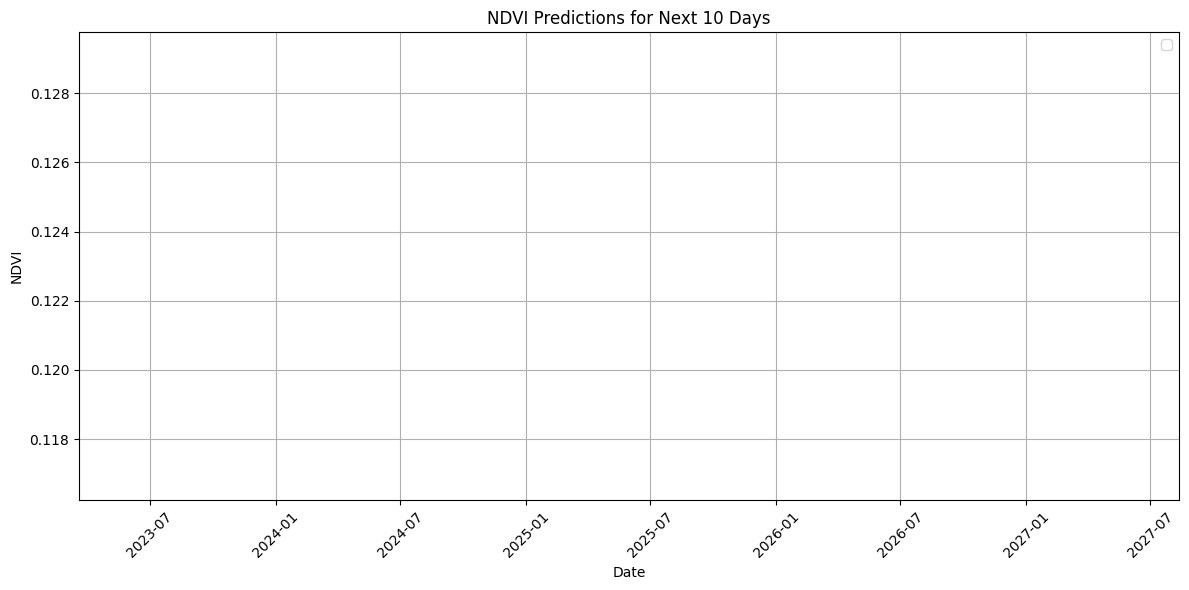

,date,predicted_ndvi,condition,reason
0,2025-05-31,0.123,OUT OF SEASON,🚜 It's not the farming season right now. Take ...


In [77]:
run_prediction_analysis([ndvi_prediction], [pred_timestamp])


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Thresholds from historical data
NDWI_THRESHOLDS = {
    'drought': minimum_ndwi_for_sowing,  # Severe water stress threshold
    'low_water': threshold_ndwi_for_growth_initiation,  # Below-average water availability
    'adequate_water': active_growth_ndwi,  # Normal irrigation conditions
    'excess_water': peak_ndwi_for_peak  # High water availability
}

# Define seasonal water demand stages (months)
NDWI_SEASONS = {
    'sowing': [11],
    'growth_initiation': [12, 1],
    'peak_water_demand': [1, 2],
    'pre_harvest': [3],
    'harvest': [4]
}

def analyze_ndwi_predictions(predictions, dates):
    analysis_results = []

    for pred, date in zip(predictions, dates):
        month = date.month
        status = {}
        status['date'] = date.strftime('%Y-%m-%d')
        status['predicted_ndwi'] = round(pred, 3)

        # 🚨 Condition 1: Severe Drought Risk
        if pred < NDWI_THRESHOLDS['drought']:
            status['condition'] = 'CRITICAL'
            status['reason'] = (
                "NDWI is extremely low! 🚨 Severe drought conditions detected. Immediate irrigation needed."
            )
            analysis_results.append(status)
            continue

        # ✅ Condition 2: Ideal Water Availability
        if pred > NDWI_THRESHOLDS['adequate_water']:
            if month in NDWI_SEASONS['growth_initiation'] + NDWI_SEASONS['pre_harvest']:
                status['condition'] = 'HEALTHY'
                status['reason'] = (
                    "NDWI indicates sufficient water for crop growth. 🌊 No urgent action required."
                )

        # ⚠️ Condition 3: Low Water Availability
        elif NDWI_THRESHOLDS['low_water'] < pred <= NDWI_THRESHOLDS['adequate_water']:
            status['condition'] = 'MODERATE'
            status['reason'] = (
                "NDWI suggests moderate water levels. 🚜 Farmers should monitor soil moisture and consider light irrigation."
            )

        # 🌾 Condition 4: Pre-Harvest or Sowing Stage (Low NDWI is Normal)
        elif pred <= NDWI_THRESHOLDS['low_water']:
            if month in NDWI_SEASONS['sowing'] or month in NDWI_SEASONS['harvest']:
                status['condition'] = 'EXPECTED'
                status['reason'] = (
                    "NDWI is low, but this is normal for the sowing or harvest period. 🌾 No immediate action needed."
                )
            else:
                status['condition'] = 'BAD'
                status['reason'] = (
                    "NDWI is too low for this period! 🌱 Farmers should inspect irrigation systems."
                )

        # 🚫 Condition 5: Out of Farming Season Alert
        if month not in sum(NDWI_SEASONS.values(), []):
            status['condition'] = 'OFF-SEASON'
            status['reason'] = "🚜 It's not farming season! Farmers should focus on soil preparation or crop planning."

        analysis_results.append(status)

    return pd.DataFrame(analysis_results)

def visualize_ndwi_predictions(analysis_df):
    plt.figure(figsize=(12, 6))

    color_map = {
        'HEALTHY': 'green',
        'EXPECTED': 'blue',
        'MODERATE': 'orange',
        'BAD': 'red',
        'CRITICAL': 'black',
        'OFF-SEASON': 'gray'
    }

    for condition in color_map.keys():
        mask = analysis_df['condition'] == condition
        if mask.any():
            plt.scatter(pd.to_datetime(analysis_df[mask]['date']),
                        analysis_df[mask]['predicted_ndwi'],
                        label=condition,
                        color=color_map[condition])

    plt.plot(pd.to_datetime(analysis_df['date']),
             analysis_df['predicted_ndwi'],
             'b--', alpha=0.5)

    plt.title('NDWI Predictions for Next 10 Days')
    plt.xlabel('Date')
    plt.ylabel('NDWI')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def run_ndwi_analysis(predictions, dates):
    analysis_df = analyze_ndwi_predictions(predictions, dates)
    print("\nNDWI Prediction Analysis Results:")
    print("=" * 80)
    for _, row in analysis_df.iterrows():
        print(f"\nDate: {row['date']}")
        print(f"Predicted NDWI: {row['predicted_ndwi']}")
        print(f"Condition: {row['condition']}")
        print(f"Reason: {row['reason']}")

    visualize_ndwi_predictions(analysis_df)
    return analysis_df



NDWI Prediction Analysis Results:

Date: 2025-05-31
Predicted NDWI: -0.236
Condition: OFF-SEASON
Reason: 🚜 It's not farming season! Farmers should focus on soil preparation or crop planning.


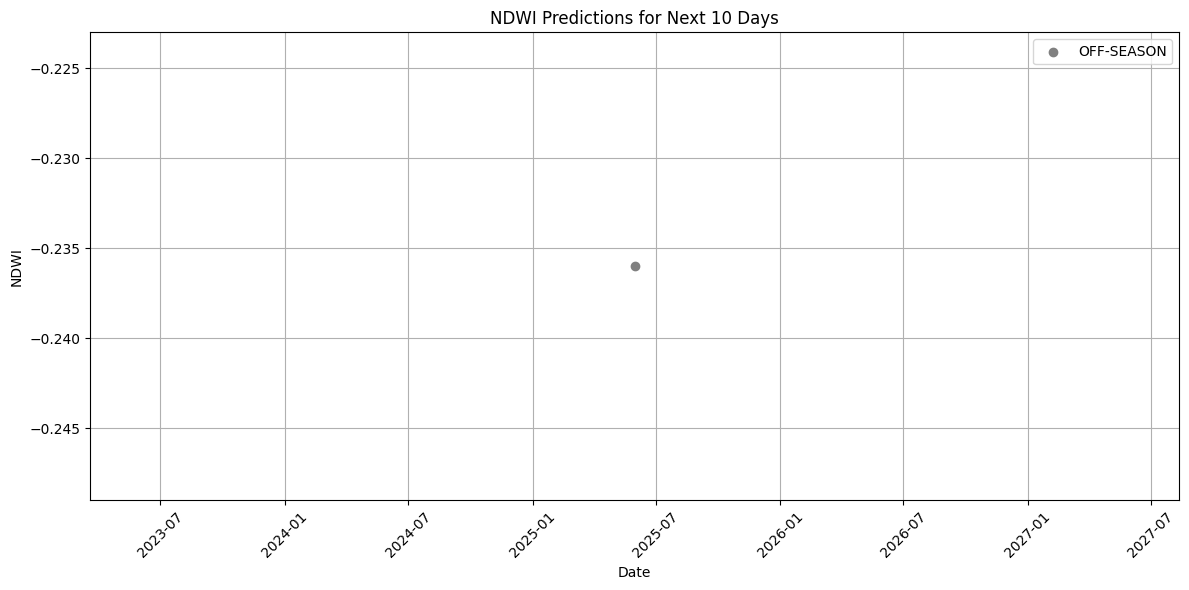

,date,predicted_ndwi,condition,reason
0,2025-05-31,-0.236,OFF-SEASON,🚜 It's not farming season! Farmers should focu...


In [10]:
run_ndwi_analysis(ndwi_prediction.tolist(), pd.to_datetime(pred_timestamp).tolist())
